In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']= '1'

In [2]:
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

## Data Generator

In [3]:
class DataGen(keras.utils.Sequence):
    def __init__(self, path, batch_size = 8, image_size = 128, shuffle = True):
        self.path = path
        self.ids = glob.glob(self.path +'/images/*')
        self.batch_size = batch_size 
        self.image_size = image_size 
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __load__(self, id_name):
        image_path = os.path.join(self.path, 'images/', id_name) 
        mask_path = os.path.join(self.path, 'masks/', id_name) 
    
        image = cv2.imread(image_path, 0) # read as Grayscale image 
        image = cv2.resize(image, (self.image_size, self.image_size))[..., np.newaxis]
        
        mask = cv2.imread(mask_path, 0) # read as Grayscale image 
        mask = cv2.resize(mask, (self.image_size, self.image_size))[..., np.newaxis]
        
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index + 1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
            
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask = []
        
        for id_name in files_batch:
            id_name = id_name.replace(self.path + '/images/', '')
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.ids)
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
        
    

## Hyperparameters

In [4]:
image_size = 256
epochs = 5
batch_size = 8

In [5]:
train_path = './final_dataset/LITS_raw/train'
valid_path = './final_dataset/LITS_raw/validation'

In [6]:
gen = DataGen(train_path, batch_size = batch_size, image_size = image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 256, 256, 1) (8, 256, 256, 1)


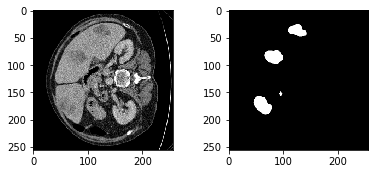

In [7]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(x[r], (image_size, image_size)), cmap = 'gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap = 'gray')

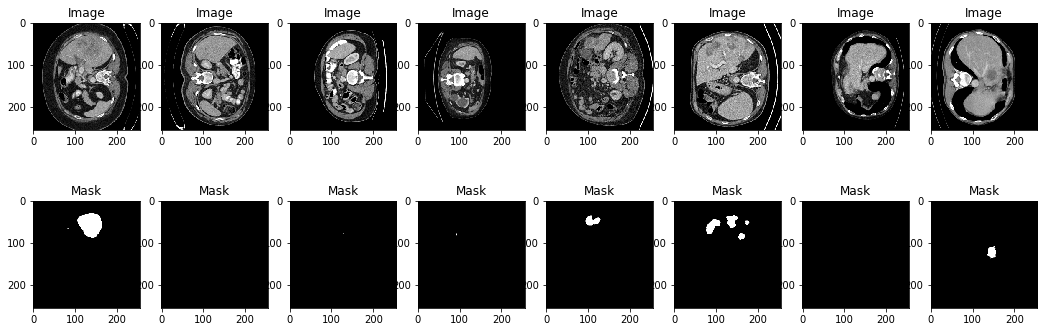

In [8]:
gen = DataGen(train_path, batch_size = batch_size, image_size = image_size, shuffle = True)
x, y = gen.__getitem__(200)

fig = plt.figure(figsize=(18,6))

for i in range(batch_size):
    a = fig.add_subplot(2, batch_size, i+1)
    imgplot = plt.imshow(np.reshape(x[i], (image_size, image_size)),cmap='gray')
    imgplot.figure(figsize=(3,3))
    a.set_title('Image')
    a = fig.add_subplot(2, batch_size, batch_size+i+1)
    imgplot = plt.imshow(np.reshape(y[i], (image_size, image_size)),cmap='gray')
    imgplot.figure(figsize=(3,3))
    a.set_title('Mask')

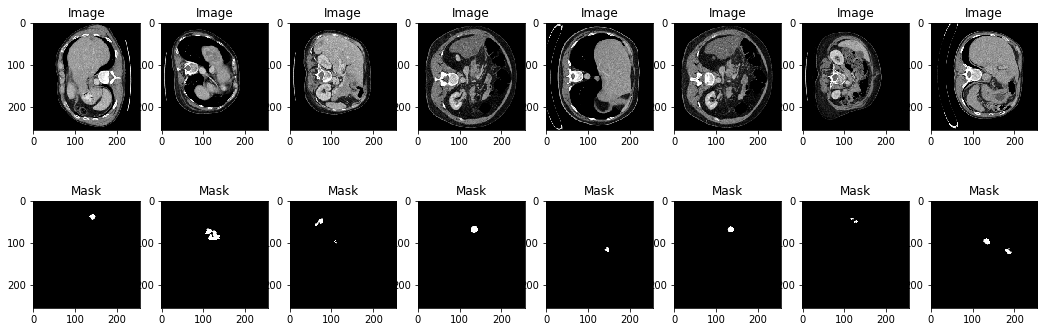

In [9]:
valid_gen = DataGen(valid_path, image_size = image_size, batch_size = batch_size)
x, y = valid_gen.__getitem__(20)

fig = plt.figure(figsize=(18,6))

for i in range(batch_size):
    a = fig.add_subplot(2, batch_size, i+1)
    imgplot = plt.imshow(np.reshape(x[i], (image_size, image_size)),cmap='gray')
    imgplot.figure(figsize=(3,3))
    a.set_title('Image')
    a = fig.add_subplot(2, batch_size, batch_size+i+1)
    imgplot = plt.imshow(np.reshape(y[i], (image_size, image_size)),cmap='gray')
    imgplot.figure(figsize=(3,3))
    a.set_title('Mask')

## Defining Loss Function

In [10]:
from keras.losses import binary_crossentropy
import keras.backend as K
import tensorflow as tf 

epsilon = 1e-5
smooth = 1

def dsc(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

def confusion(y_true, y_pred):
    smooth=1
    y_pred_pos = K.clip(y_pred, 0, 1)
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.clip(y_true, 0, 1)
    y_neg = 1 - y_pos
    tp = K.sum(y_pos * y_pred_pos)
    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg) 
    prec = (tp + smooth)/(tp+fp+smooth)
    recall = (tp+smooth)/(tp+fn+smooth)
    return prec, recall

def tp(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pos = K.round(K.clip(y_true, 0, 1))
    tp = (K.sum(y_pos * y_pred_pos) + smooth)/ (K.sum(y_pos) + smooth) 
    return tp 

def tn(y_true, y_pred):
    smooth = 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos 
    tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth )
    return tn 

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

## UNet Model

In [11]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256, 256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    # model.compile(optimizer = Adam(lr = 1e-4), loss = bce_dice_loss, metrics = [dsc])
    model.compile(optimizer = Adam(lr = 1e-3), loss = bce_dice_loss, metrics = [dsc])
    model.summary()
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [12]:
# model_checkpoint = ModelCheckpoint('unet_v2.hdf5', monitor='loss',verbose=1, save_best_only=True)
# model.fit_generator(myGene,steps_per_epoch=300,epochs=1,callbacks=[model_checkpoint])
# testGene = testGenerator("data/membrane/test")
# results = model.predict_generator(testGene,30,verbose=1)
# saveResult("data/membrane/test",results)

In [13]:
model = unet()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

## Define Callbacks

In [14]:
def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model_unet.h5', monitor='val_loss', mode='min', verbose = 1, save_best_only=True)

# "./keras.model",monitor='val_my_iou_metric', 
#                                   mode = 'max', save_best_only=True, verbose=1

## Training the model

In [15]:
tf.__version__

'2.3.0'

In [16]:
train_gen = DataGen(train_path, image_size = image_size, batch_size = batch_size)
valid_gen = DataGen(valid_path, image_size = image_size, batch_size = batch_size)

train_steps = len(glob.glob('./final_dataset/LITS_raw/train/masks/*'))//batch_size
valid_steps = len(glob.glob('./final_dataset/LITS_raw/validation/masks/*'))//batch_size

In [17]:
print(train_steps)
print(valid_steps)

955
36


In [18]:
for name in glob.glob('./final_dataset/LITS_raw/train/images/*'):
    file = os.path.isfile(name.replace('images', 'masks'))
    if file == False:
        print(name, 'is the problem')

In [ ]:
model_checkpoint = ModelCheckpoint('unet_v4_0911.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
history = model.fit_generator(train_gen, 
                              validation_data = valid_gen, 
                              steps_per_epoch = train_steps, 
                              validation_steps = valid_steps, 
                              epochs = 40, 
                              callbacks = [model_checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
955/955 [==============================] - ETA: 0s - loss: 1.3304 - dsc: 0.1796
Epoch 00001: val_loss improved from inf to 0.95495, saving model to unet_v4_0911.hdf5
955/955 [==============================] - 143s 149ms/step - loss: 1.3304 - dsc: 0.1796 - val_loss: 0.9550 - val_dsc: 0.1197
Epoch 2/40
955/955 [==============================] - ETA: 0s - loss: 0.6655 - dsc: 0.3701
Epoch 00002: val_loss improved from 0.95495 to 0.60204, saving model to unet_v4_0911.hdf5
955/955 [==============================] - 137s 144ms/step - loss: 0.6655 - dsc: 0.3701 - val_loss: 0.6020 - val_dsc: 0.4176
Epoch 3/40
955/955 [==============================] - ETA: 0s - loss: 0.5215 - dsc: 0.5095
Epoch 00003: val_loss improved from 0.60204 to 0.53101, saving model to unet_v4_0911.hdf5
955/955 [==============================] - 137s 144ms/step - loss: 0.5215 - dsc: 0.5095 - val_loss: 0.5310 - val_dsc: 0.4907
Epoch 4/40

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
plt.plot(history.history['my_iou_metric'][1:])
plt.plot(history.history['val_my_iou_metric'][1:])
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')

plt.title('model IOU')

plt.subplot(1,2,2)
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend(['train','Validation'], loc='upper left')
plt.title('model loss')
gc.collect()

## Testing the model

In [ ]:
# Find best threshhold blah blah 

In [ ]:
model = UNet()
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])
model.load_weights('best_model_unet.h5')

In [ ]:
dice_coef(result[0], y[0])

In [ ]:
result[result> 0.5] = 1
result[result< 0.5] = 0

In [ ]:
dice_coef(result[0], y[0])

In [ ]:
r = random.randint(0, len(x)-1)

fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(x[r], (image_size, image_size)), cmap = 'gray')
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap = 'gray')

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[0], (image_size, image_size)), cmap = 'gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap = 'gray')

In [ ]:
fig = plt.figure()
fig.subplots_adjust(hspace = 0.4, wspace = 0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1], (image_size, image_size)), cmap = 'gray')

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap = 'gray')

In [ ]:
def dsc(seg,gt):
    dice = np.sum(seg[gt==1])*2.0 / (np.sum(seg) + np.sum(gt))
    return dice

In [ ]:
import cv2
import glob
import numpy as np
from tqdm import tqdm
model = unet()
naam = 'unet_v4_0903.hdf5'
model.load_weights(naam)
test_path = '/home/centos/kelly/final_dataset/test/images/*.png'
files = glob.glob(test_path)
dsc_scores = np.zeros((len(files),1))
j=0
for FilePath in tqdm(files):
    img = cv2.imread(FilePath,0)
    [m,n] = img.shape
    img = cv2.resize(img, (128,128))
    img = img / img.max()
#     img = trans.resize(img,target_size)
    img = img[np.newaxis,..., np.newaxis]
    result = model.predict(img)
    result = np.squeeze(result)
    result = cv2.resize(result, (n,m),interpolation = cv2.INTER_NEAREST)
    result = np.where(result>0.5,1,0)
#     result[result> result.mean()/2] = 1
#     result[result< result.mean()/2] = 0
    save_path = FilePath.replace('images','preds')
#     cv2.imwrite(save_path,result*255)
    FilePath = save_path.replace('preds','masks')
    ref = cv2.imread(FilePath,0)/255
    dsc_scores[j] = dsc(result,ref)
    j = j+1

In [ ]:
type(result)

In [ ]:
dsc_scores

In [ ]:
plt.plot(dsc_scores)

In [ ]:
plt.hist(dsc_scores, bins = 20)

In [ ]:
dsc_scores.mean()

In [ ]:
z = np.where(dsc_scores==0)
z[0].shape

In [ ]:
import cv2
z = np.where(dsc_scores==0)    
for id in z[0]:
    image = cv2.imread(files[id], cv2.IMREAD_GRAYSCALE) 
    
